In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import pickle
import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Stylometri_experiment/dataset.csv")
df.head()

,text,author
0,কারওয়ান বাজার এলাকার মাদক ব্যবসা নিয়ন্ত্রণ ক...,Humayun Ahmed
1,গুলশান এলাকার একটা ফ্যাট সে ভাড়া করে। এই ফ্ল্...,Humayun Ahmed
2,আমাকে শোভা ডাকতে পারে না। আমাকে ডাকে– শো শো শো...,Humayun Ahmed
3,রান্না ভালো হয় নি। শোভা আপুর রান্নার হাত জঘন্...,Humayun Ahmed
4,অবশ্যই । দুপুরে তুমি খাবে। ছোট্ট একটা কাজ করতে...,Humayun Ahmed


In [6]:
df.author.value_counts()

Bivutibhushon Bondopoddhay     100
Munir Chowdhury                100
MD Jafor Iqbal                 100
Promoth Chowdury               100
Sawkat Osman                   100
Shorot Chandro                 100
Bankimchandra Chattopadhyay    100
Humayun Ahmed                  100
Robindronath Tagore            100
Shomoresh Mojumdar             100
Manik Bondopoddhay             100
Sufia Kamal                    100
Taarashankar Bondopoddhay      100
Syed Waliullah                 100
Name: author, dtype: int64

## Preprocessing

In [9]:
import re
df['prep']=df.text.apply(lambda x: [i for i in re.sub(r'[^\u0980-\u09E3 A-Za-z]+', ' ', str(x)).split() if len(i) > 1])

In [10]:
df= df[df.prep.apply(lambda x: len(x)) > 0]

In [11]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['target']=le.fit_transform(df['author'])

In [12]:
df[['author', 'target']].drop_duplicates(subset=['author']).sort_values(by=['target']).reset_index(drop=True)

,author,target
0,Bankimchandra Chattopadhyay,0
1,Bivutibhushon Bondopoddhay,1
2,Humayun Ahmed,2
3,MD Jafor Iqbal,3
4,Manik Bondopoddhay,4
5,Munir Chowdhury,5
6,Promoth Chowdury,6
7,Robindronath Tagore,7
8,Sawkat Osman,8
9,Shomoresh Mojumdar,9


In [ ]:
# !pip install bnlp_toolkit

In [13]:
df.head(3)

,text,author,prep,target
0,কারওয়ান বাজার এলাকার মাদক ব্যবসা নিয়ন্ত্রণ ক...,Humayun Ahmed,"[কারওয়ান, বাজার, এলাকার, মাদক, ব্যবসা, নিয়ন্...",2
1,গুলশান এলাকার একটা ফ্যাট সে ভাড়া করে। এই ফ্ল্...,Humayun Ahmed,"[গুলশান, এলাকার, একটা, ফ্যাট, সে, ভাড়া, করে, ...",2
2,আমাকে শোভা ডাকতে পারে না। আমাকে ডাকে– শো শো শো...,Humayun Ahmed,"[আমাকে, শোভা, ডাকতে, পারে, না, আমাকে, ডাকে, শো...",2


## Data Partitioning

In [14]:
X = df['prep']
y = df['target']

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape, X_val.shape, X_test.shape))

Training shape: (1120,)
Validation shape: (140,)
Testing shape: (140,)


## Load fastText pre-trained model

In [19]:
!unzip "/content/drive/MyDrive/Clickbait/Copy of cc.bn.300.zip" -d /content

Archive:  /content/drive/MyDrive/Clickbait/Copy of cc.bn.300.zip
  inflating: /content/cc.bn.300.vec  


In [20]:
from gensim.models import KeyedVectors

path = '/content/cc.bn.300.vec'
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

## Feature Extraction

In [64]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [65]:
x_train_vectorized = embedding_vectorizer(fastText_model, X_train)
x_train_vectorized = pd.DataFrame(x_train_vectorized).add_prefix('col_')

In [66]:
x_val_vectorized = embedding_vectorizer(fastText_model, X_val)
x_val_vectorized = pd.DataFrame(x_val_vectorized).add_prefix('col_')

In [67]:
x_test_vectorized = embedding_vectorizer(fastText_model, X_test)
x_test_vectorized = pd.DataFrame(x_test_vectorized).add_prefix('col_')

In [68]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=14)
y_val_k = to_categorical(y_val, num_classes=14)
y_test_k = to_categorical(y_test, num_classes=14)

In [69]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

In [80]:
np.random.seed(2)
rn.seed(3)

history = History()

model = Sequential()
model.add(Dense(512, input_dim=300, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="elu"))
model.add(Dropout(0.5))
model.add(Dense(14, activation="softmax"))

model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=['accuracy'])
# model.summary()

model.fit(np.array(x_train_vectorized), np.array(y_train_k), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val_k)), 
          epochs=150,  
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 1120 samples, validate on 140 samples
Epoch 1/150
1120/1120 [==============================] - 1s 733us/step - loss: 2.5796 - accuracy: 0.1241 - val_loss: 2.4464 - val_accuracy: 0.2143
Epoch 2/150
1120/1120 [==============================] - 0s 194us/step - loss: 2.2762 - accuracy: 0.2723 - val_loss: 2.0099 - val_accuracy: 0.4143
Epoch 3/150
1120/1120 [==============================] - 0s 209us/step - loss: 1.8749 - accuracy: 0.4098 - val_loss: 1.6433 - val_accuracy: 0.5500
Epoch 4/150
1120/1120 [==============================] - 0s 202us/step - loss: 1.5584 - accuracy: 0.5018 - val_loss: 1.4149 - val_accuracy: 0.6071
Epoch 5/150
1120/1120 [==============================] - 0s 190us/step - loss: 1.3517 - accuracy: 0.5857 - val_loss: 1.2426 - val_accuracy: 0.6214
Epoch 6/150
1120/1120 [==============================] - 0s 204us/step - loss: 1.2168 - accuracy: 0.6098 - val_loss: 1.1129 - val_accuracy: 0.6786
Epoch 7/150
1120/1120 [==============================] - 0s 222us/step 

In [ ]:
# import pickle
# with open("/content/drive/My Drive/Munna_Research/Experiment/model_2.rifat", 'wb') as out_file:
#  pickle.dump(model, out_file)

In [ ]:
# from sklearn.externals import joblib

# # save the model to disk
# filename = "/content/drive/My Drive/Munna_Research/Experiment/model_1.joblib"
# joblib.dump(model, filename)

In [81]:
# for visualization
his_train_acc = history.history['accuracy']
his_val_acc = history.history['val_accuracy']

his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

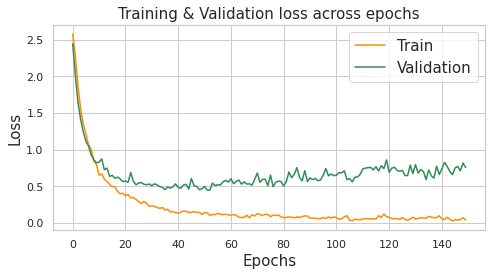

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(his_train_loss,'darkorange')
plt.plot(his_val_loss, 'seagreen')

plt.title("Training & Validation loss across epochs",fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.legend(['Train', 'Validation'], fontsize=15 ,loc='upper right')
plt.tight_layout()
# plt.savefig("multiclass_loss_vs_epochs_fastText_munna.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [83]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test_k), verbose=0)

In [84]:
train_accuracy = his_train_acc[-1]
val_accuracy = his_val_acc[-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 2), round(val_accuracy, 2), round(test_accuracy, 2)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.99
Validation,0.91
Test,0.89


In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [86]:
y_pred = model.predict(np.array(x_test_vectorized))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.89


In [87]:
# generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [88]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*14,list(le.inverse_transform(list(range(14))))], 
                 columns=[['Predicted']*14,list(le.inverse_transform(list(range(14))))])

p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

Confusion Matrix: 


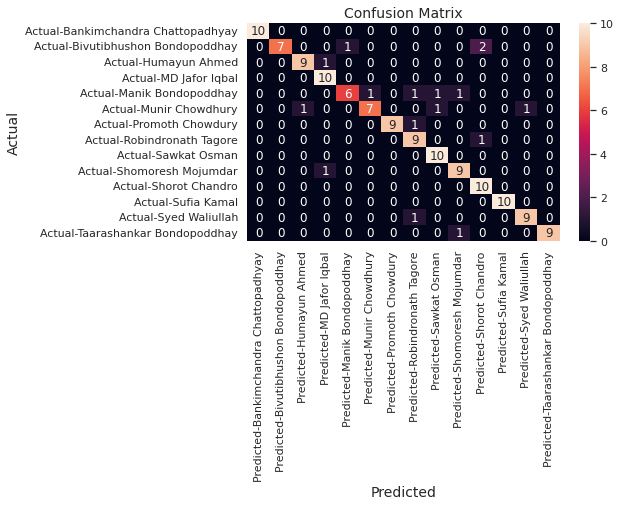

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.set()
f = sns.heatmap(p, annot=True, fmt='d')
plt.title("Confusion Matrix", fontdict={'fontsize': 14})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual",  fontsize=14)
plt.show()

f.get_figure().savefig("multiclass_confusion_matrix_fastText_munna.jpg", dpi=300, bbox_inches='tight')

In [91]:
target_names = list(le.inverse_transform(list(range(14))))
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

                             precision    recall  f1-score   support

Bankimchandra Chattopadhyay       1.00      1.00      1.00        10
 Bivutibhushon Bondopoddhay       1.00      0.70      0.82        10
              Humayun Ahmed       0.90      0.90      0.90        10
             MD Jafor Iqbal       0.83      1.00      0.91        10
         Manik Bondopoddhay       0.86      0.60      0.71        10
            Munir Chowdhury       0.88      0.70      0.78        10
           Promoth Chowdury       1.00      0.90      0.95        10
        Robindronath Tagore       0.75      0.90      0.82        10
               Sawkat Osman       0.83      1.00      0.91        10
         Shomoresh Mojumdar       0.82      0.90      0.86        10
             Shorot Chandro       0.77      1.00      0.87        10
                Sufia Kamal       1.00      1.00      1.00        10
             Syed Waliullah       0.90      0.90      0.90        10
  Taarashankar Bondopoddhay      